In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shp
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.dbf
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.README.html
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shx
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.VERSION.txt
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.prj


In [299]:
df_train=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
hol=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transact=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
hol = hol.rename(columns={"type": "type_hol"})
stores=stores.rename(columns={'type':'type_store'})

## Combiinig/edditing/adding the data

In [300]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [301]:
len(df_train.groupby('date')) 

1684

In [302]:
# drop the last few from the test set andd merge with df_train 
oil=oil[:1206]
oil=oil.rename(columns={"dcoilwtico": "oil"})
combined=pd.merge(df_train,oil,on='date', how='outer')

# There are just 3 days for which we don't  know oil price neither sales
(len(combined)-len(df_train),len(combined))

(3, 3000891)

In [303]:
combined[combined['sales'].isna()]

,id,date,store_nbr,family,sales,onpromotion,oil
637956,NaN,2013-12-25,NaN,NaN,NaN,NaN,NaN
1286605,NaN,2014-12-25,NaN,NaN,NaN,NaN,NaN
1935254,NaN,2015-12-25,NaN,NaN,NaN,NaN,NaN


In [304]:
# merging stores 
combined=pd.merge(combined, stores,on='store_nbr', how='outer')
len(combined)-3000891
# =0 so no duplicates

0

In [393]:
#Adding day/month week
combined['year']=combined['date'].apply(lambda x: x.split('-')[0]).astype(int)
combined['month']=combined['date'].apply(lambda x: x.split('-')[1]).astype(int)
combined['day']=combined['date'].apply(lambda x: x.split('-')[2]).astype(int)


#and day of the week
import calendar
from datetime import date

def date_to_day(year,month,day):
    d = calendar.weekday(year, month, day)
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return days[d]

combined['day_of_the_week']=combined.apply(lambda row: date_to_day(row['year'], row['month'], row['day']), axis=1)
combined['week_number'] = combined.apply(lambda row: date(row['year'], row['month'], row['day']).isocalendar()[1], axis=1)

AttributeError: 'tuple' object has no attribute 'isocalendar'

In [306]:
#merging transactions
combined = combined.merge(
   transact[['date', 'store_nbr', 'transactions']],
    on=['date', 'store_nbr'],
    how='left'
)

In [307]:
len(combined)-3000891
# =0 so no duplicates

0

In [308]:
#Looking for transferred holidays - not many, can deal with it later 
transf=hol[hol.transferred==True]
transf

,date,type_hol,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [309]:
hol = pd.get_dummies(hol, columns=['locale'],prefix='Hol')
#We can adjust weights here or later
hol['Hol_Local']=hol['Hol_Local']*1
hol['Hol_National']=hol['Hol_National']*1
hol['Hol_Regional']=hol['Hol_Regional']*1


In [310]:
# Looking at local holidays
hol_loc=hol[hol['Hol_Local']==1]
hol_loc=hol_loc.rename(columns={'locale_name':'city'})
hol_loc=hol_loc[['date', 'type_hol', 'city', 'description', 'transferred',
       'Hol_Local']]
hol_loc

,date,type_hol,city,description,transferred,Hol_Local
0,2012-03-02,Holiday,Manta,Fundacion de Manta,False,1
2,2012-04-12,Holiday,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Riobamba,Cantonizacion de Riobamba,False,1
5,2012-05-12,Holiday,Puyo,Cantonizacion del Puyo,False,1
...,...,...,...,...,...,...
339,2017-12-05,Additional,Quito,Fundacion de Quito-1,False,1
340,2017-12-06,Holiday,Quito,Fundacion de Quito,True,1
341,2017-12-08,Holiday,Loja,Fundacion de Loja,False,1
342,2017-12-08,Transfer,Quito,Traslado Fundacion de Quito,False,1


In [311]:
# Looking at Regional holidays
hol_reg=hol[hol['Hol_Regional']==1]
hol_reg=hol_reg.rename(columns={'locale_name':'state'})
hol_reg=hol_reg[['date', 'type_hol', 'state', 'description', 'transferred',
       'Hol_Regional']]
hol_reg

,date,type_hol,state,description,transferred,Hol_Regional
1,2012-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
7,2012-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1
23,2012-11-06,Holiday,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,1
24,2012-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False,1
47,2013-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
58,2013-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1
76,2013-11-06,Holiday,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,1
77,2013-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False,1
96,2014-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
112,2014-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1


In [312]:
# Looking at National holidays
hol_nat=hol[hol['Hol_National']==1]
hol_nat=hol_nat[['date', 'type_hol', 'description', 'transferred',
       'Hol_National']]
hol_nat

,date,type_hol,description,transferred,Hol_National
14,2012-08-10,Holiday,Primer Grito de Independencia,False,1
19,2012-10-09,Holiday,Independencia de Guayaquil,True,1
20,2012-10-12,Transfer,Traslado Independencia de Guayaquil,False,1
21,2012-11-02,Holiday,Dia de Difuntos,False,1
22,2012-11-03,Holiday,Independencia de Cuenca,False,1
...,...,...,...,...,...
345,2017-12-22,Additional,Navidad-3,False,1
346,2017-12-23,Additional,Navidad-2,False,1
347,2017-12-24,Additional,Navidad-1,False,1
348,2017-12-25,Holiday,Navidad,False,1


In [316]:
combined['type_hol']=None

In [317]:
# Now merging/mapping national holidays 
 
# Create a mapping of holidays
holiday_nat_map = dict(zip(hol_nat['date'], hol_nat['Hol_National']))
holiday_nat_type_map = dict(zip(hol_nat['date'], hol_nat['type_hol']))
# Assign holidays based on mapping  
combined['hol_Nat'] = combined['date'].map(holiday_nat_map)
combined.loc[combined['type_hol'].isna(), 'type_hol'] = combined['date'].map(holiday_nat_type_map)

In [319]:
len( set(hol_nat['date'].unique())- set(combined['date'].unique()))
#so there are 22 holidays that we left - if needed we can add them 

22

In [324]:
# Now merging/mapping local holidays 
holiday_loc_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['Hol_Local']))
holiday_loc_type_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['type_hol']))

combined['hol_Loc'] = combined.apply(lambda row: holiday_loc_map.get((row['date'], row['city'])), axis=1)
combined.loc[combined['type_hol'].isna(), 'type_hol']= combined.loc[combined['type_hol'].isna()].apply(lambda row: holiday_loc_type_map.get((row['date'], row['city'])), axis=1)

In [ ]:
# We lost 32 local holidays, again we can add them if we need
len(set(hol_loc['date'].unique())- set(combined['date'].unique()))

In [325]:
# Now merging/mapping reg holidays 
holiday_reg_map = dict(zip(zip(hol_reg['date'], hol_reg['state'].str.strip()), hol_reg['Hol_Regional']))
holiday_reg_type_map = dict(zip(zip(hol_reg['date'], hol_reg['state'].str.strip()), hol_reg['type_hol']))
combined['hol_Reg'] = combined.apply(lambda row: holiday_reg_map.get((row['date'], row['state'])), axis=1)
combined.loc[combined['type_hol'].isna(), 'type_hol'] = combined.loc[combined['type_hol'].isna()].apply(lambda row: holiday_reg_type_map.get((row['date'], row['state'])), axis=1)

In [340]:
combined[['hol_Nat','hol_Reg','hol_Loc']]=combined[['hol_Nat','hol_Reg','hol_Loc']].fillna(0)


In [388]:
combined[combined['hol_Nat']+combined['hol_Reg']+combined['hol_Loc']>1][150:200]

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,year,month,day,day_of_the_week,transactions,hol_Nat,type_hol,hol_Loc,hol_Reg
1171353,233922.0,2013-05-12,22.0,HOME CARE,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171354,233923.0,2013-05-12,22.0,LADIESWEAR,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171355,233924.0,2013-05-12,22.0,LAWN AND GARDEN,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171356,233925.0,2013-05-12,22.0,LINGERIE,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171357,233926.0,2013-05-12,22.0,"LIQUOR,WINE,BEER",0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171358,233927.0,2013-05-12,22.0,MAGAZINES,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171359,233928.0,2013-05-12,22.0,MEATS,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171360,233929.0,2013-05-12,22.0,PERSONAL CARE,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171361,233930.0,2013-05-12,22.0,PET SUPPLIES,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0
1171362,233931.0,2013-05-12,22.0,PLAYERS AND ELECTRONICS,0.000,0.0,NaN,Puyo,Pastaza,C,7.0,2013,5,12,Sunday,NaN,1.0,Event,1.0,0.0


In [348]:
combined

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,year,month,day,day_of_the_week,transactions,hol_Nat,type_hol,hol_Loc,hol_Reg
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,2013,1,1,Tuesday,NaN,1.0,Holiday,0.0,0.0
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,2013,1,1,Tuesday,NaN,1.0,Holiday,0.0,0.0
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,2013,1,1,Tuesday,NaN,1.0,Holiday,0.0,0.0
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13.0,2013,1,1,Tuesday,NaN,1.0,Holiday,0.0,0.0
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13.0,2013,1,1,Tuesday,NaN,1.0,Holiday,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000886,3000754.0,2017-08-15,54.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,47.57,El Carmen,Manabi,C,3.0,2017,8,15,Tuesday,802.0,0.0,None,0.0,0.0
3000887,3000755.0,2017-08-15,54.0,SEAFOOD,3.0,0.0,47.57,El Carmen,Manabi,C,3.0,2017,8,15,Tuesday,802.0,0.0,None,0.0,0.0
3000888,NaN,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,12,25,Wednesday,NaN,1.0,Holiday,0.0,0.0
3000889,NaN,2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,25,Thursday,NaN,1.0,Holiday,0.0,0.0


In [397]:
 combined.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'oil',
       'city', 'state', 'type_store', 'cluster', 'year', 'month', 'day',
       'day_of_the_week', 'transactions', 'hol_Nat', 'type_hol', 'hol_Loc',
       'hol_Reg', 'week_number'],
      dtype='object')

In [402]:
combined=combined[['date','year', 'month','week_number', 'day',  'day_of_the_week', 
                  'store_nbr', 'city', 'state', 'type_store', 'cluster', 
                  'family', 'sales', 'onpromotion', 'oil','transactions', 
                  'hol_Nat', 'hol_Reg', 'hol_Loc', 'type_hol'
                  ]] 
combined

,date,year,month,week_number,day,day_of_the_week,store_nbr,city,state,type_store,cluster,family,sales,onpromotion,oil,transactions,hol_Nat,hol_Reg,hol_Loc,type_hol
0,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,13.0,AUTOMOTIVE,0.0,0.0,NaN,NaN,1.0,0.0,0.0,Holiday
1,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,13.0,BABY CARE,0.0,0.0,NaN,NaN,1.0,0.0,0.0,Holiday
2,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,13.0,BEAUTY,0.0,0.0,NaN,NaN,1.0,0.0,0.0,Holiday
3,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,13.0,BEVERAGES,0.0,0.0,NaN,NaN,1.0,0.0,0.0,Holiday
4,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,13.0,BOOKS,0.0,0.0,NaN,NaN,1.0,0.0,0.0,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000886,2017-08-15,2017,8,33,15,Tuesday,54.0,El Carmen,Manabi,C,3.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,47.57,802.0,0.0,0.0,0.0,None
3000887,2017-08-15,2017,8,33,15,Tuesday,54.0,El Carmen,Manabi,C,3.0,SEAFOOD,3.0,0.0,47.57,802.0,0.0,0.0,0.0,None
3000888,2013-12-25,2013,12,52,25,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Holiday
3000889,2014-12-25,2014,12,52,25,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Holiday


In [403]:
 combined.to_csv('/kaggle/working/combined.csv', index=False)  # Save without the index column

## Cheking the type of store:

In [9]:
 for typ in  set(combined['type_store']):
    filtered_df=combined.loc[combined['type_store']==typ][['family','sales']]
    family_sales = filtered_df.groupby('family')['sales'].sum().astype(int)
    top_3=family_sales.sort_values(ascending=False)[:3]
    print('Type= ',typ,'\n top 3=', top_3,'\n')

Type=  C 
 top 3= family
GROCERY I    65558144
BEVERAGES    33103352
CLEANING     21319073
Name: sales, dtype: int64 

Type=  B 
 top 3= family
GROCERY I    54953102
BEVERAGES    29572844
CLEANING     15450788
Name: sales, dtype: int64 

Type=  nan 
 top 3= Series([], Name: sales, dtype: int64) 

Type=  E 
 top 3= family
GROCERY I    20680983
BEVERAGES    14602000
CLEANING      5739097
Name: sales, dtype: int64 

Type=  A 
 top 3= family
GROCERY I    107869009
BEVERAGES     73335263
PRODUCE       47208554
Name: sales, dtype: int64 

Type=  D 
 top 3= family
GROCERY I    101766057
BEVERAGES     71050081
PRODUCE       54039577
Name: sales, dtype: int64 



### Clusters 



In [351]:
combined.columns 

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'oil',
       'city', 'state', 'type_store', 'cluster', 'year', 'month', 'day',
       'day_of_the_week', 'transactions', 'hol_Nat', 'type_hol', 'hol_Loc',
       'hol_Reg'],
      dtype='object')

In [365]:
(combined['store_nbr'].unique(),combined['cluster'].unique(),combined[ 'city'].unique())

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., nan]),
 array([13.,  8.,  9.,  4.,  6., 15.,  7.,  3., 12., 16.,  1., 10.,  2.,
         5., 11., 14., 17., nan]),
 array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
        'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
        'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
        'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen', nan],
       dtype=object))

In [381]:
for clust in combined['cluster'].unique():
    print( 'In cluster',clust, 'there are the following cities: ', combined[combined['cluster']==clust]['city'].unique())

In cluster 13.0 there are the following cities:  ['Quito' 'Manta']
In cluster 8.0 there are the following cities:  ['Quito']
In cluster 9.0 there are the following cities:  ['Quito' 'Ambato']
In cluster 4.0 there are the following cities:  ['Santo Domingo' 'Loja' 'Machala']
In cluster 6.0 there are the following cities:  ['Quito' 'Cayambe' 'Santo Domingo' 'Guayaquil' 'Cuenca']
In cluster 15.0 there are the following cities:  ['Quito' 'Latacunga' 'Ibarra' 'Guaranda']
In cluster 7.0 there are the following cities:  ['Riobamba' 'Puyo']
In cluster 3.0 there are the following cities:  ['Santo Domingo' 'Guayaquil' 'Quevedo' 'Playas' 'Machala' 'El Carmen']
In cluster 12.0 there are the following cities:  ['Quito']
In cluster 16.0 there are the following cities:  ['Quito']
In cluster 1.0 there are the following cities:  ['Guayaquil' 'Salinas' 'Daule']
In cluster 10.0 there are the following cities:  ['Guayaquil' 'Babahoyo' 'Libertad' 'Esmeraldas']
In cluster 2.0 there are the following cities:

### Feature importance


In [410]:
combined.columns.drop(['sales','date', 'year', 'month', 'week_number', 'day'])
combined_encoded = pd.get_dummies(combined, columns=['day_of_the_week', 'city', 'state', 'type_store',
       'family',  'type_hol'])

In [439]:
combined_encoded=combined_encoded.fillna(0)
Groc_1=combined_encoded[combined_encoded['family_GROCERY I']]
bevar=combined_encoded[combined_encoded['family_BEVERAGES']]

In [441]:
clean=combined_encoded[combined_encoded['family_CLEANING']]

In [436]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = Groc_1.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = Groc_1['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                       Feature  Importance
0                    store_nbr    0.252352
52                type_store_A    0.251740
3                          oil    0.145269
2                  onpromotion    0.127452
1                      cluster    0.035649
..                         ...         ...
70           family_GROCERY II    0.000000
72   family_HOME AND KITCHEN I    0.000000
73  family_HOME AND KITCHEN II    0.000000
74      family_HOME APPLIANCES    0.000000
58            family_BABY CARE    0.000000

[96 rows x 2 columns]


In [440]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = bevar.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = bevar['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                       Feature  Importance
2                  onpromotion    0.282370
52                type_store_A    0.218537
0                    store_nbr    0.141709
3                          oil    0.137087
1                      cluster    0.067009
..                         ...         ...
69            family_GROCERY I    0.000000
71             family_HARDWARE    0.000000
72   family_HOME AND KITCHEN I    0.000000
73  family_HOME AND KITCHEN II    0.000000
70           family_GROCERY II    0.000000

[96 rows x 2 columns]


In [442]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = clean.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = clean['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                       Feature  Importance
52                type_store_A    0.236649
0                    store_nbr    0.226904
3                          oil    0.154055
2                  onpromotion    0.081062
1                      cluster    0.054063
..                         ...         ...
70           family_GROCERY II    0.000000
71             family_HARDWARE    0.000000
72   family_HOME AND KITCHEN I    0.000000
73  family_HOME AND KITCHEN II    0.000000
64             family_CLEANING    0.000000

[96 rows x 2 columns]


### Geopandas


In [371]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load Ecuador boundary or province shapefile
ecuador = gpd.read_file('/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shp')

In [11]:
set(combined['city'])

{'Ambato',
 'Babahoyo',
 'Cayambe',
 'Cuenca',
 'Daule',
 'El Carmen',
 'Esmeraldas',
 'Guaranda',
 'Guayaquil',
 'Ibarra',
 'Latacunga',
 'Libertad',
 'Loja',
 'Machala',
 'Manta',
 'Playas',
 'Puyo',
 'Quevedo',
 'Quito',
 'Riobamba',
 'Salinas',
 'Santo Domingo',
 nan}

In [372]:
# Data for Ecuadorian cities with their latitude and longitude
data = {
    'city': [
        'Ambato', 'Babahoyo', 'Cayambe', 'Cuenca', 'Daule', 'El Carmen',
        'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad',
        'Loja', 'Machala', 'Manta', 'Playas', 'Puyo', 'Quevedo', 'Quito', 
        'Riobamba', 'Salinas', 'Santo Domingo'
    ],
    'latitude': [
        -1.2417, -1.8019, 0.0409, -2.9006, -1.8617, -0.3686, 0.9592,
        -1.5933, -2.1700, 0.3517, -0.9352, -2.2333, -3.9931, -3.2586,
        -0.9621, -2.6336, -1.4921, -1.0132, -0.2299, -1.6635, -2.2144,
        -0.2547
    ],
    'longitude': [
        -78.6197, -79.5344, -78.1451, -79.0045, -79.9777, -79.4447, -79.6517,
        -79.0017, -79.9224, -78.1223, -78.6099, -80.9000, -79.2042, -79.9600,
        -80.7127, -80.3898, -77.9853, -79.4608, -78.5249, -78.6546, -80.9582,
        -79.1754
    ]
}

# Create a DataFrame from the data dictionary
gf = pd.DataFrame(data)

# Convert DataFrame to GeoDataFrame using the latitude and longitude columns
geol = gpd.GeoDataFrame(gf, geometry=gpd.points_from_xy(gf['longitude'], gf['latitude']))

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326), typical for latitude and longitude
geol.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
print(geol)

             city  latitude  longitude                    geometry
0          Ambato   -1.2417   -78.6197  POINT (-78.61970 -1.24170)
1        Babahoyo   -1.8019   -79.5344  POINT (-79.53440 -1.80190)
2         Cayambe    0.0409   -78.1451   POINT (-78.14510 0.04090)
3          Cuenca   -2.9006   -79.0045  POINT (-79.00450 -2.90060)
4           Daule   -1.8617   -79.9777  POINT (-79.97770 -1.86170)
5       El Carmen   -0.3686   -79.4447  POINT (-79.44470 -0.36860)
6      Esmeraldas    0.9592   -79.6517   POINT (-79.65170 0.95920)
7        Guaranda   -1.5933   -79.0017  POINT (-79.00170 -1.59330)
8       Guayaquil   -2.1700   -79.9224  POINT (-79.92240 -2.17000)
9          Ibarra    0.3517   -78.1223   POINT (-78.12230 0.35170)
10      Latacunga   -0.9352   -78.6099  POINT (-78.60990 -0.93520)
11       Libertad   -2.2333   -80.9000  POINT (-80.90000 -2.23330)
12           Loja   -3.9931   -79.2042  POINT (-79.20420 -3.99310)
13        Machala   -3.2586   -79.9600  POINT (-79.96000 -3.25

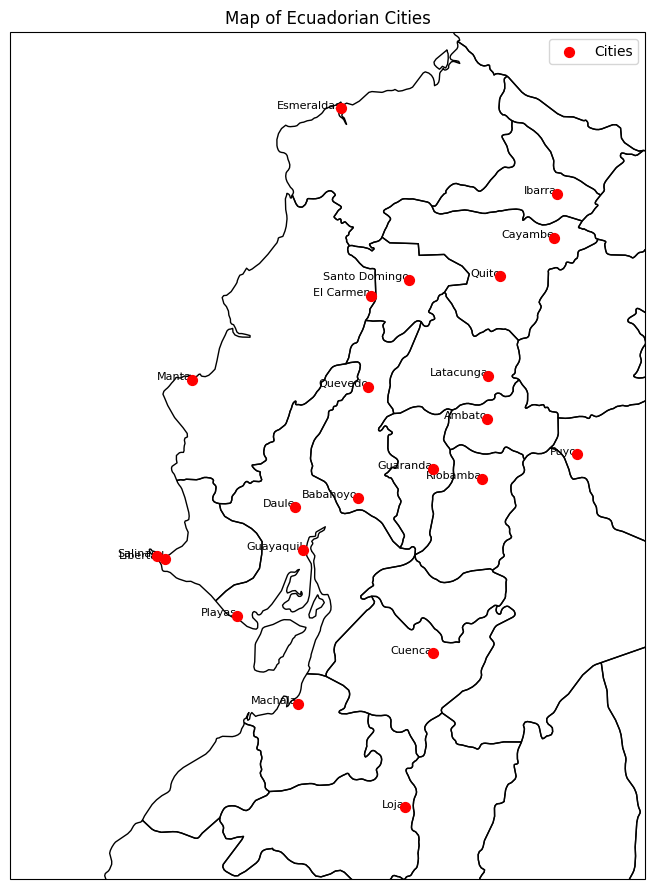

In [380]:
 
# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -77.5, -4.5, 1.5])  # Set extent for Ecuador, make sure values are reasonable

# Plot Ecuador provinces
ecuador.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Plot cities
geol.plot(ax=ax, color='red', marker='o', markersize=50, label='Cities', zorder=5)

# Add city names for better visualization
for x, y, label in zip(geol.geometry.x, geol.geometry.y, geol['city']):
    ax.text(x, y, label, fontsize=8, ha='right', color='black')

plt.title('Map of Ecuadorian Cities')
plt.legend()
plt.show()